Siyu Wu Oct 25th
Normalize batch by: x_batch_normalized = (x_batch - mean) / std
In cell 14, test loss after 1000 epochs reach to 1.99

In [1]:
!pip install torchviz

In [2]:
# Import relevant python modules
import sys, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# The datasets needed are computed by the `ComputeGluon.py` script in PseudoData
filename1='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
filename2='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-4.dat'
filename3='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-5.dat'
filename4='https://raw.githubusercontent.com/rabah-khalek/TF_tutorials/master/PseudoData/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-6.dat'

# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# Loading data from txt file
# Change filename1 to another filename for data that extends to lower x
# (see exercises at the bottom of this notebook)
df = pd.read_csv(filename1,
                 sep="\s+",
                 skiprows=lines_to_skip,
                 usecols=[0,1,2],
                 names=columns)

# Splitting data randomly to train and test using the sklearn library
df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

# Sort the split data according to their x values
df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")

print("Data parsing is done!")

Data parsing is done!


In [3]:
print(df_train)

            x  gluon_cv  gluon_sd
0    0.001000  4.480675  0.523964
1    0.001007  4.478519  0.520743
2    0.001014  4.476361  0.517539
3    0.001021  4.474202  0.514349
4    0.001028  4.472040  0.511176
..        ...       ...       ...
993  0.952796 -0.001109  0.003990
994  0.959401 -0.000878  0.003423
996  0.972747 -0.000634  0.002707
997  0.979490 -0.000494  0.002179
999  0.993116 -0.000144  0.000697

[800 rows x 3 columns]


In [4]:
! pip install torchvision

In [5]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split

In [6]:
import torch.nn as nn
import torch.nn.functional as F


##################################################################
# Building NN from the PyTorch API (nn.Linear)
##################################################################

class Torch_Model(nn.Module):

    def __init__(self, n_features, n_neurons, n_outputs):

        super(Torch_Model, self).__init__()

        self.fc1 = nn.Linear(n_features, n_neurons) # Hidden Layer 1
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_neurons, n_outputs) # Output Layer

    # Evaluates and returns output
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
#set seed
torch.manual_seed(42)

In [9]:
# Hyperparameters
n_features = 1
n_neurons = 20
n_outputs = 1
learning_rate = 0.001
batch_size = 20
n_epochs = 1000

In [10]:
# Load data

#print(df_train.to_numpy())
#train_dataset, val_dataset = random_split(df_train.to_numpy(), [80, 20])

train_loader = DataLoader(df_train.to_numpy(), batch_size=batch_size)
val_loader = DataLoader(df_test.to_numpy(), batch_size=batch_size)



In [11]:
# Initialize network
model = Torch_Model(n_features, n_neurons, n_outputs).to(device)

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y, dy):
        model.train()
        yhat = model(x)
        loss = loss_fn(y/dy, yhat/dy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [14]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

plt.figure(figsize=(15,10))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data
x_train = torch.tensor(df_train['x'].values.reshape(-1, 1)).float().to(device)
y_train = torch.tensor(df_train['gluon_cv'].values.reshape(-1, 1)).float().to(device)
dy_train = torch.tensor(df_train['gluon_sd'].values.reshape(-1, 1)).float().to(device)

train_dataset = TensorDataset(x_train, y_train, dy_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

x_test = torch.tensor(df_test['x'].values.reshape(-1, 1)).float().to(device)
y_test = torch.tensor(df_test['gluon_cv'].values.reshape(-1, 1)).float().to(device)
dy_test = torch.tensor(df_test['gluon_sd'].values.reshape(-1, 1)).float().to(device)

test_dataset = TensorDataset(x_test, y_test, dy_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize network
model = Torch_Model(n_features, n_neurons, n_outputs).to(device)

<Figure size 1500x1000 with 0 Axes>

Normalize Batch by : x_batch_normalized = (x_batch - mean) / std
Then calculate loss: loss = train_step(x_batch_normalized, y_batch, dy_batch)

In [15]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#Normalize batch
train_step = make_train_step(model, criterion, optimizer)

train_data = []
for x_batch, _, _ in train_loader:
    train_data.append(x_batch)
train_data = torch.cat(train_data)  
mean = train_data.mean(dim=0)        # Compute mean
std = train_data.std(dim=0)          # Compute std deviation

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    train_loss = 0
    for x_batch, y_batch, dy_batch in train_loader:
       
        x_batch_normalized = (x_batch - mean) / std
        
        loss = train_step(x_batch_normalized, y_batch, dy_batch)
        train_loss += loss

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    with torch.no_grad():
        test_loss = 0
        for x_batch, y_batch, dy_batch in test_loader:
            model.eval()
            # Normalize test batches using the training mean and std
            x_batch_normalized = (x_batch - mean) / std
            
            y_pred = model(x_batch_normalized)
            loss = criterion(y_batch / dy_batch, y_pred / dy_batch)
            test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [100/1000], Train Loss: 28.0188, Test Loss: 20.6326
Epoch [200/1000], Train Loss: 21.4102, Test Loss: 13.7172
Epoch [300/1000], Train Loss: 17.6406, Test Loss: 11.1795
Epoch [400/1000], Train Loss: 14.8082, Test Loss: 9.3171
Epoch [500/1000], Train Loss: 13.3928, Test Loss: 8.3662
Epoch [600/1000], Train Loss: 11.9582, Test Loss: 7.4177
Epoch [700/1000], Train Loss: 11.1884, Test Loss: 6.8870
Epoch [800/1000], Train Loss: 10.3677, Test Loss: 6.3796
Epoch [900/1000], Train Loss: 9.5776, Test Loss: 5.9052
Epoch [1000/1000], Train Loss: 8.7603, Test Loss: 5.4070


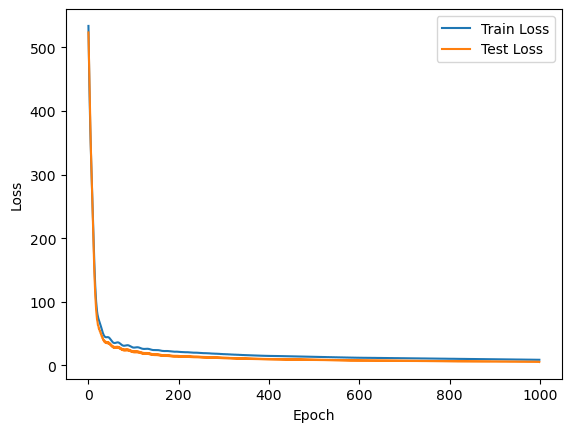

In [ ]:
# Plot train and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))

# Visualize model graph
x_sample = torch.tensor([[0.1]]).float().to(device)
make_dot(model(x_sample), params=dict(model.named_parameters()))
plt.show()

plt.figure(figsize=(15,10))

# Evaluate the model on the test set
model.eval()
y_pred = model(x_test)

# Plot predictions vs true values
plt.errorbar(df_train["x"],y_train.numpy(),yerr=dy_train.numpy(),fmt='.',color='darkblue',label='$d_{g}^{train}$',alpha=0.3)
plt.fill_between(df_train["x"],df_train["gluon_cv"]+df_train["gluon_sd"],
                  df_train["gluon_cv"]-df_train["gluon_sd"] ,color='blue',
                  alpha=0.1, label='$\sigma_{g}$')
plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), label='True Values')
plt.plot(x_test.cpu().numpy(), y_pred.detach().cpu().numpy(), label='Predictions')
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('gluon PDF')
plt.legend()
plt.show()